## 2次元の畳み込みニューラルネットワークスクラッチ

#### データセットの用意
引き続きMNISTデータセットを使用します。2次元畳み込み層へは、28×28の状態で入力します。


今回は白黒画像ですからチャンネルは1つしかありませんが、チャンネル方向の軸は用意しておく必要があります。


`(n_samples, n_channels, height, width)`の`NCHW`または`(n_samples, height, width, n_channels)`の`NHWC`どちらかの形にしてください。

In [1]:
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
print(X_train.shape) # (48000, 784)
print(X_test.shape) # (12000, 784)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [4]:
# 軸を追加
X_train=X_train[:, np.newaxis, :]
X_test=X_test[:, np.newaxis, :]
print(X_train.shape)
print(X_test.shape)

(60000, 1, 28, 28)
(10000, 1, 28, 28)


In [5]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [6]:
# 軸を追加
y_train_one_hot=y_train_one_hot[:, np.newaxis, :]
#y_test_one_hot=y_test_one_hot[:, np.newaxis, :]
print(y_train_one_hot.shape)
#print(y_test_one_hot.shape)

(60000, 1, 10)


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)
print(y_train.shape)
print(y_val.shape)

(48000, 1, 28, 28)
(12000, 1, 28, 28)
(48000, 1, 10)
(12000, 1, 10)


In [9]:
# テスト用にデコード
y_test_decode = np.argmax(y_val, axis=2).reshape(-1,)
print(y_test_decode.shape)
print(y_test_decode)

(12000,)
[4 2 7 ... 4 1 2]


## 【問題1】2次元畳み込み層の作成  
>1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。
>
>フォワードプロパゲーションの数式は以下のようになります。
>
>$
a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}
$
>
>ai,j,m : 出力される配列のi行j列、mチャンネルの値
>
>i : 配列の行方向のインデックス
>
>j : 配列の列方向のインデックス
>
>m : 出力チャンネルのインデックス
>
>K : 入力チャンネル数
>
>Fh,Fw : 高さ方向（h）と幅方向（w）のフィルタのサイズ
>
>x(i+s),(j+t),k : 入力の配列の(i+s)行(j+t)列、kチャンネルの値
>
>ws,t,k,m : 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み
>
>bm : mチャンネルへの出力のバイアス項
>
>全てスカラーです。
>


>次に更新式です。1次元畳み込み層や全結合層と同じ形です。
>
>$
w_{s,t,k,m}^{\prime} = w_{s,t,k,m} - \alpha \frac{\partial L}{\partial w_{s,t,k,m}} \\
b_{m}^{\prime} = b_{m} - \alpha \frac{\partial L}{\partial b_{m}}
$
>
>α : 学習率
>
>$\frac{\partial L}{\partial w_{s,t,k,m}}$: $w_{s,t,k,m}$に関する損失 L の勾配
>
>$\frac{\partial L}{\partial b_{m}}$: bm に関する損失 L の勾配
>
>勾配$\frac{\partial L}{\partial w_{s,t,k,m}}$や$\frac{\partial L}{\partial b_{m}}$を求めるためのバックプロパゲーションの数式が以下である。
>
>$
\frac{\partial L}{\partial w_{s,t,k,m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1} \frac{\partial L}{\partial a_{i,j,m}}x_{(i+s)(j+t),k}\\
\frac{\partial L}{\partial b_{m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}
$
>
>$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi行j列、mチャンネルの値
>
>$N_{out,h},N_{out,w}$: 高さ方向（h）と幅方向（w）の出力のサイズ
>
>前の層に流す誤差の数式は以下です。
>
>$
\frac{\partial L}{\partial x_{i,j,k}} = \sum_{m=0}^{M-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1} \frac{\partial L}{\partial a_{(i-s),(j-t),m}}w_{s,t,k,m}
$
>
>$\frac{\partial L}{\partial x_{i,j,k}}$: 前の層に流す誤差の配列のi列j行、kチャンネルの値
>
>M  : 出力チャンネル数
>
>ただし、  $i-s<0$または$i-s>N_{out,h}-1$または$j-t<0$または$j-t>N_{out,w}-1$のとき$\frac{\partial L}{\partial a_{(i-s),(j-t),m}} =0$です。

In [10]:
class Conv2d():
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_filter, n_channel, Fs, Ft, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.n_filter = n_filter
        self.n_channel = n_channel
        self.Fs = Fs
        self.Ft = Ft
        
        self.W = initializer.W(self.n_filter, self.n_channel, self.Fs, self.Ft)
        self.B = initializer.B(self.n_filter)
        
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = X
        
        self.n_input=self.X.shape[1]#.shape[1]
        
        self.n_input_h=self.X.shape[2]#.shape[1]
        self.n_input_w=self.X.shape[3]#.shape[1]
        
        #F=3
        stride=1
        padding=0
        #self.n_output1 = self.X_i - self.Fs
        #self.n_output2 = self.X_j - self.Ft
        self.n_output_h, self.n_output_w = self.output_size(self.n_input_h, self.n_input_w, self.Fs, self.Ft, P=padding, S=stride)
        
        A = np.empty((self.n_filter, self.n_channel, self.n_output_h, self.n_output_w))
        for f in range(self.n_filter):#出力チャンネル
            for c in range(self.n_channel):#入力チャンネル
                for i in range(self.n_input_h - self.Fs):#self.n_output　　タテ
                    for j in range(self.n_input_w - self.Ft):#self.n_output　ヨコ
                        A[f, c, i, j] += np.sum(X[f, c, i:i+self.Fs:, j:j+self.Ft]*self.W[f, c])+self.B[f]
   
        self.A = A
        
        return self.A
    
    
    def backward(self, dA, Z):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # 実際の処理においてはラベルは不要
        
        # 更新
        self, dZ = self.optimizer.update(self, dA, self.X)
        
        return dZ
    
    def output_size(self, n_input_h, n_input_w, Fs, Ft, P=0, S=1):
        """
        出力数数える
        """
        n_output_h = int((n_input_h + 2*P - Fs)/S + 1)
        n_output_w = int((n_input_w + 2*P - Ft)/S + 1)

        return (n_output_h, n_output_w)
                 

#### 初期化方法のクラス化

In [11]:
class SimpleInitializer():
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_filter, n_channel, Fs, Ft):
        """
        重みの初期化
        Parameters
        ----------
        n_filter : int
          フィルタのサイズ

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_filter, n_channel, Fs, Ft)
        
        return W
    
    
    def B(self, n_filter):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(n_filter, )
        
        return B

#### 更新式

In [12]:
class RenewalFormula():
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer, dA, X):#dA, Z
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        #print(f"dA.shape：　{dA.shape}")
            
        dA_num = layer.n_output_h*layer.n_output_w
        dW_temp = np.zeros((layer.n_filter, dA_num, layer.n_channel, layer.Fs, layer.Ft))
        #print(f"layer.n_output_h：　{layer.n_output_h}")
        #print(f"layer.n_output_w：　{layer.n_output_w}")
        
        for f in range(layer.n_filter):
            for c in range(layer.n_channel):
                a = 0
                for i in range(layer.n_output_h):
                    for j in range(layer.n_output_w):
                        dW_temp[f, a, c] += layer.W[f, c]*dA[f, c, i, j]
                        a += 1

        #print(f"dW_temp.shape：　{dW_temp.shape}")
        
        
        dW = np.sum(dW_temp, axis=1)
        #print(f"dW.shape：　{dW.shape}")
        
        # (48000, 1, 28, 28)
        #print(f"X.shape：　{X.shape}")
        dX=np.zeros(X.shape)
        
        for f in range(layer.n_filter):
            for c in range(layer.n_channel):
                a = 0
                for i in range(layer.n_output_h):
                    for j in range(layer.n_output_w):
                        dX[f, c, i:i+layer.Fs, j:j+layer.Ft] += dW[f, c]
                        a += 1
        
        #　バイアスの更新
        dB = np.sum(dA, axis=(1,2, 3))#, axis=0 , axis=1
        #print(f"dB.shape：　{dB.shape}")
        
        layer.W = layer.W - self.lr*(dW)
        layer.B = layer.B - self.lr*(dB)
        
        return (layer, dX)
        

#### 活性化関数

In [13]:
class Tanh():
    """
    活性化関数（シグモイド関数）のクラス

    Attributes
    ----------
    """
    def forward(self, X):
        """
        準伝播用

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ
        """
        Z = np.tanh(X)
        
        return Z
    

    def backward(self, X, dZ):
        """
        逆伝播用

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ
        """
        dA = dZ*(1 - np.tanh(X)**2)
        
        return dA

#### インスタンス化

In [14]:
initializer=SimpleInitializer(0.01)
optimizer=RenewalFormula(1)
n_filter=4#写真の枚数と同じ
n_channel=1#白黒、RGB
Fs=3
Ft=3
# インスタンス化
CNN_conv2d = Conv2d(n_filter, n_channel, Fs, Ft, initializer, optimizer)

print("W.shape: {}".format(CNN_conv2d.W.shape))
print("B.shape: {}".format(CNN_conv2d.B.shape))

W.shape: (4, 1, 3, 3)
B.shape: (4,)


In [15]:
# CNN　順伝播
CNN_conv2d.forward(X_train[0:4])
A=CNN_conv2d.A
print(A.shape)
#print(A)

(4, 1, 26, 26)


In [16]:
# 活性化関数　順伝播
tanh = Tanh()
Z = tanh.forward(A)
print(Z.shape)
#print(Z)

(4, 1, 26, 26)


In [17]:
# 活性化関数　逆伝播
dA = tanh.backward(A, Z)#本当はdZ
print(dA.shape)
#print(dA)

(4, 1, 26, 26)


In [18]:
# CNN　逆伝播
dX = CNN_conv2d.backward(dA, X_train[0:4])
print(f"dX.shape：　{dX.shape}")
print(f"dX：　{dX}")

dX.shape：　(4, 1, 28, 28)
dX：　[[[[ 0.10561713  0.12815135  0.13577607 ...  0.13577607  0.03015893
     0.00762472]
   [ 0.12175163  0.04597762  0.2092768  ...  0.2092768   0.08752517
     0.16329918]
   [ 0.09998831  0.08884563  0.28216584 ...  0.28216584  0.18217753
     0.19332021]
   ...
   [ 0.09998831  0.08884563  0.28216584 ...  0.28216584  0.18217753
     0.19332021]
   [-0.00562882 -0.03930572  0.14638977 ...  0.14638977  0.15201859
     0.18569549]
   [-0.02176332  0.04286801  0.07288904 ...  0.07288904  0.09465236
     0.03002103]]]


 [[[ 0.03930765  0.26171075  0.36598669 ...  0.36598669  0.32667905
     0.10427595]
   [ 0.17888583  0.28396661 -0.13615064 ... -0.13615064 -0.31503647
    -0.42011725]
   [ 0.11208131  0.5523926   0.22380343 ...  0.22380343  0.11172212
    -0.32858917]
   ...
   [ 0.11208131  0.5523926   0.22380343 ...  0.22380343  0.11172212
    -0.32858917]
   [ 0.07277366  0.29068186 -0.14218326 ... -0.14218326 -0.21495692
    -0.43286512]
   [-0.06680453  0

## 【問題2】2次元畳み込み後の出力サイズ  
>畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

クラス内にoutput_sizeメソッドを作成。  

In [19]:
n_input_h = 28
n_input_w = 28
Fs = 3
Ft = 3
P=0
S=1

n_output_h, n_output_w = CNN_conv2d.output_size(n_input_h, 
                                                                                                n_input_w, 
                                                                                                Fs, 
                                                                                                Ft, 
                                                                                                P=P,
                                                                                                S=S
                                                                                               )
print(f"高さのアウトプット数：　{n_output_h}")
print(f"幅のアウトプット数：　{n_output_w}")

高さのアウトプット数：　26
幅のアウトプット数：　26


## 【問題3】最大プーリング層の作成  
>最大プーリング層のクラスMaxPool2Dを作成してください。  
>プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。
>
>$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$
>
>Pi,j : i行j列への出力する場合の入力配列のインデックスの集合。 
>
>Sh×Sw の範囲内の行（p）と列（q）
>
>Sh,Sw : 高さ方向（h）と幅方向（w）のストライドのサイズ
>
>(p,q)∈Pi,j : Pi,j に含まれる行（p）と列（q）のインデックス
>
>ai,j,m : 出力される配列のi行j列、kチャンネルの値
>
>xp,q,k : 入力の配列のp行q列、kチャンネルの値
>
>ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。
>バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス 
(p,q) を保持しておく必要があります。フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。

In [20]:
class MaxPool2D():
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_filter, n_channel, Sh, Sw):
        #self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.n_filter = n_filter
        self.n_channel = n_channel
        self.Sh = Sh
        self.Sw = Sw
        
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = X
        #print(X.shape)
        self.n_input=self.X.shape[1]#.shape[1]
        
        self.n_input_h=self.X.shape[2]#.shape[1]
        self.n_input_w=self.X.shape[3]#.shape[1]
        
        self.n_output_h=int(self.n_input_h/self.Sh)
        self.n_output_w=int(self.n_input_w/self.Sw)
        
        A = np.empty((self.n_filter, self.n_channel, self.n_output_h, self.n_output_w))
        A_index = []
        
        for f in range(self.n_filter):#出力チャンネル
            for c in range(self.n_channel):#入力チャンネル
                for i in range(self.n_output_h):#self.n_output　　タテ 【割り切れる数】
                    for j in range(self.n_output_w):#self.n_output　ヨコ 【割り切れる数】
                        A[f, c, i, j] = np.max(X[f, c, i*self.Sh:i*self.Sh+self.Sh:, j*self.Sw:j*self.Sw+self.Sw])

                    
        self.A = A
        #print(f"self.A.shape：　{self.A.shape}")
        
        return self.A
    
    
    def backward(self, A):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # 実際の処理においてはラベルは不要
        
        # 更新
        X_max = np.zeros(self.X.shape)
        self.A
        a = 0
        for f in range(self.n_filter):#出力チャンネル
            for c in range(self.n_channel):#入力チャンネル
                for i in range(self.n_output_h):#self.n_output　　タテ
                    for j in range(self.n_output_w):#self.n_output　ヨコ 
                        for h in range(self.Sw):#self.Sw　　タテ
                            for w in range(self.Sw):#self.Sw　ヨコ
                                # マックスプーリングの値と一致するXはそのままXの値を入力
                                if self.A[f, c, i, j]==self.X[f, c, i*self.Sh+h, j*self.Sw+w]:
                                    X_max[f, c, i, j] = self.X[f, c, i*self.Sh+h, j*self.Sw+w]

        self.X_max = X_max
        
        return self.X_max

        

In [21]:
n_filter=4#写真の枚数と同じ
n_channel=1#白黒、RGB
Sh=4#【割り切れる数】
Sw=4#【割り切れる数】

# インスタンス化
max_pool_2d = MaxPool2D(n_filter, n_channel, Sh, Sw)

In [22]:
A_max = max_pool_2d.forward(dX)
print(f"A_max.shape：　{A_max.shape}")
print(f"A_max：　{A_max}")

A_max.shape：　(4, 1, 7, 7)
A_max：　[[[[ 0.28216584  0.28216584  0.28216584  0.28216584  0.28216584
     0.28216584  0.28216584]
   [ 0.28216584  0.28216584  0.28216584  0.28216584  0.28216584
     0.28216584  0.28216584]
   [ 0.28216584  0.28216584  0.28216584  0.28216584  0.28216584
     0.28216584  0.28216584]
   [ 0.28216584  0.28216584  0.28216584  0.28216584  0.28216584
     0.28216584  0.28216584]
   [ 0.28216584  0.28216584  0.28216584  0.28216584  0.28216584
     0.28216584  0.28216584]
   [ 0.28216584  0.28216584  0.28216584  0.28216584  0.28216584
     0.28216584  0.28216584]
   [ 0.28216584  0.28216584  0.28216584  0.28216584  0.28216584
     0.28216584  0.28216584]]]


 [[[ 0.5523926   0.36598669  0.36598669  0.36598669  0.36598669
     0.36598669  0.36598669]
   [ 0.5523926   0.22380343  0.22380343  0.22380343  0.22380343
     0.22380343  0.22380343]
   [ 0.5523926   0.22380343  0.22380343  0.22380343  0.22380343
     0.22380343  0.22380343]
   [ 0.5523926   0.22380343  0.22

In [23]:
X_max = max_pool_2d.backward(A_max)
print(f"X_max.shape：　{X_max.shape}")
print(f"X_max：　{X_max}")

X_max.shape：　(4, 1, 28, 28)
X_max：　[[[[ 0.28216584  0.28216584  0.28216584 ...  0.          0.
     0.        ]
   [ 0.28216584  0.28216584  0.28216584 ...  0.          0.
     0.        ]
   [ 0.28216584  0.28216584  0.28216584 ...  0.          0.
     0.        ]
   ...
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]]]


 [[[ 0.5523926   0.36598669  0.36598669 ...  0.          0.
     0.        ]
   [ 0.5523926   0.22380343  0.22380343 ...  0.          0.
     0.        ]
   [ 0.5523926   0.22380343  0.22380343 ...  0.          0.
     0.        ]
   ...
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]]]


 [[[ 0.26734671  0.

## 【問題5】平滑化  
>平滑化するためのFlattenクラスを作成してください。
>
>フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。
>
>この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。



In [24]:
class Flatten():
    """
    Flatten平滑化
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def forward(self, X):
        # チャンネル、高さ、幅の3次元を1次元にreshape
        self.X = X
        X_flat = X.reshape(X.shape[0],-1,1)
        
        return X_flat 
        
    def backward(self, X):
        # バックワードのときに再びreshapeによって形を戻します
        X = X.reshape(self.X.shape)
        
        return X 
        
        
        

In [25]:
flat = Flatten()
X_flat = flat.forward(X_max)
print(f"A_max.shape：　{X_flat.shape}")
#print(f"X_flat：　{X_flat}")

A_max.shape：　(4, 784, 1)


In [26]:
X_restore = flat.backward(X_flat)
print(f"A_max.shape：　{X_restore.shape}")
#print(f"_restore：　{_restore}")

A_max.shape：　(4, 1, 28, 28)


## 検証

## 【問題6】学習と推定  
>作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。
>
>精度は低くともまずは動くことを目指してください。

In [27]:
class FC():
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
    
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = X
        
        A=[]
        for f in range(self.X.shape[0]):
            A_temp = self.X[f,:].T@self.W[f,:]+self.B.reshape(-1,1).T
            A.append(A_temp)
        
        return np.array(A)
    
    
    def backward(self, dA, Z):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # 更新
        self, dZ = self.optimizer.update(self, dA, Z)
        
        return dZ

In [28]:
class SimpleInitializerFC:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(4, n_nodes1, n_nodes2)
        
        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(n_nodes2,)
        
        return B

In [29]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer, dA, Z):#Z3, Y, 
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        dB = np.sum(dA, axis=0)#バッチサイズ分の合計
        
        dW=[]
        for f in range(dA.shape[0]):
            dW.append(Z[f,:]*dA[f,:])
        dW = np.array(dW)
        
        
        dZ =[]
        for f in range(layer.W.shape[0]):
            dZ.append(layer.W[f,:]@dA[f,:].T)
        dZ=np.array(dZ)
        
        #【問題3】
        layer.W = layer.W - self.lr*(dW)
        layer.B = layer.B - self.lr*(dB)
        
        
        return (layer, np.array(dZ))
        

In [30]:
class Softmax():
    """
    活性化関数（シグモイド関数）のクラス

    Attributes
    ----------
    """
    def forward(self, X):
        """
        準伝播用

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ
        """
        Z = np.exp(X)/(np.sum(np.exp(X)))#, axis=()
        
        return Z
    

    def backward(self, X, y):
        """
        逆伝播用
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ
        """
        dA =X - y
        
        # 目的関数（損失関数）　交差エントロピー誤差
        nb = y.shape[0]#バッチサイズ
        L = -(1/nb)*(np.sum(y*np.log(X)))
        
        return (dA, L)

#### インスタンス化

In [31]:
# FC インスタンス化
FC_Q6 = FC(36,10, SimpleInitializerFC(0.01), SGD(0.01))

In [32]:
# Conv2d インスタンス化

initializer=SimpleInitializer(0.01)
optimizer=RenewalFormula(1)
n_filter=4#写真の枚数と同じ
n_channel=1#白黒、RGB
Fs=3
Ft=3
# インスタンス化
CNN_conv2d_Q6 = Conv2d(n_filter, n_channel, Fs, Ft, initializer, optimizer)

print("W.shape: {}".format(CNN_conv2d_Q6.W.shape))
print("B.shape: {}".format(CNN_conv2d_Q6.B.shape))

W.shape: (4, 1, 3, 3)
B.shape: (4,)


In [33]:
# MaxPool2D　インスタンス化

n_filter=4#写真の枚数と同じ
n_channel=1#白黒、RGB
Sh=4#【割り切れる数】
Sw=4#【割り切れる数】

# インスタンス化
max_pool_2d_Q6 = MaxPool2D(n_filter, n_channel, Sh, Sw)

In [34]:
# インスタンス化
tanh_Q6 = Tanh()

In [35]:
# インスタンス化
softmax_Q6 = Softmax()

In [36]:
# インスタンス化
flat_Q6 = Flatten()

### 学習

#### 順伝播

In [37]:
# CNN　順伝播
A1_q6=CNN_conv2d_Q6.forward(X_train[0:4])#0:4
print(f"CNN　順伝播：　{A1_q6.shape}")
# 活性化関数　順伝播
Z1_q6 = tanh_Q6.forward(A1_q6)
print(f"活性化関数　順伝播：　{Z1_q6.shape}")
# Max Poolinb　順伝播
X_max_q6 = max_pool_2d_Q6.forward(Z1_q6)
print(f"Max Poolinb　順伝播：　{X_max_q6.shape}")
# Flatten　順伝播
X_flat_q6 = flat.forward(X_max_q6)
print(f"Flatten　順伝播：　{X_flat_q6.shape}")
# 全結合層　順伝播
A3_q6 = FC_Q6.forward(X_flat_q6)
print(f"全結合層　順伝播：　{A3_q6.shape}")
# 活性化関数　順伝播
Z3_q6 = softmax_Q6.forward(A3_q6)
print(f"softmax関数　順伝播：　{Z3_q6.shape}")

CNN　順伝播：　(4, 1, 26, 26)
活性化関数　順伝播：　(4, 1, 26, 26)
Max Poolinb　順伝播：　(4, 1, 6, 6)
Flatten　順伝播：　(4, 36, 1)
全結合層　順伝播：　(4, 1, 10)
softmax関数　順伝播：　(4, 1, 10)


#### 逆伝播

In [38]:
# 活性化関数　逆伝播
dA3_q6, _ = softmax_Q6.backward(Z3_q6, y_train[0:4])#  A3_q6
print(f"活性化関数　逆伝播：　{dA3_q6.shape}")
# 全結合層　逆伝播
dZ2_q6 = FC_Q6.backward(dA3_q6, X_flat_q6)#dA2, Z1
print(f"全結合層　逆伝播：　{dZ2_q6.shape}")
# Flatten　逆伝播
X_restore_q6 = flat.backward(dZ2_q6)
print(f"Flatten　逆伝播：　{X_restore_q6.shape}")
# Max Poolinb　逆伝播
X_max_q6 = max_pool_2d_Q6.backward(X_restore_q6)
print(f"Max Poolinb　逆伝播：　{X_max_q6.shape}")
# 活性化関数　逆伝播
dA_q6 = tanh_Q6.backward(A1_q6, X_max_q6)
print(f"活性化関数　逆伝播：　{dA_q6.shape}")
# CNN　逆伝播
dX_q6 = CNN_conv2d_Q6.backward(dA_q6, X_train[0:4])
print(f"CNN　逆伝播：　{dX_q6.shape}")

活性化関数　逆伝播：　(4, 1, 10)
全結合層　逆伝播：　(4, 36, 1)
Flatten　逆伝播：　(4, 1, 6, 6)
Max Poolinb　逆伝播：　(4, 1, 26, 26)
活性化関数　逆伝播：　(4, 1, 26, 26)
CNN　逆伝播：　(4, 1, 28, 28)


#### 推定

In [39]:
# CNN　順伝播
A1_pred=CNN_conv2d_Q6.forward(X_val[0:4])#0:4
print(f"CNN　順伝播：　{A1_pred.shape}")
# 活性化関数　順伝播
Z1_pred = tanh_Q6.forward(A1_pred)
print(f"活性化関数　順伝播：　{Z1_pred.shape}")
# Max Poolinb　順伝播
X_max_pred = max_pool_2d_Q6.forward(Z1_pred)
print(f"Max Poolinb　順伝播：　{X_max_pred.shape}")
# Flatten　順伝播
X_flat_pred = flat.forward(X_max_pred)
print(f"Flatten　順伝播：　{X_flat_pred.shape}")
# 全結合層　順伝播
A3_pred = FC_Q6.forward(X_flat_pred)
print(f"全結合層　順伝播：　{A3_pred.shape}")
# 活性化関数　順伝播
Z3_pred = tanh_Q6.forward(A3_pred)
print(f"活性化関数　順伝播：　{Z3_pred.shape}")

CNN　順伝播：　(4, 1, 26, 26)
活性化関数　順伝播：　(4, 1, 26, 26)
Max Poolinb　順伝播：　(4, 1, 6, 6)
Flatten　順伝播：　(4, 36, 1)
全結合層　順伝播：　(4, 1, 10)
活性化関数　順伝播：　(4, 1, 10)


In [40]:
Z3_pred

array([[[-2.99912715e-02,  2.69500576e-02, -2.05726125e-02,
         -1.09925164e-02, -5.64986711e-02,  2.03159718e-02,
          5.20998575e-02,  4.22744812e-02, -2.61648367e-02,
          3.56347876e-03]],

       [[ 2.81036449e-02, -7.52138418e-02,  1.25786869e-03,
          3.51966666e-02, -7.51072628e-05,  1.27545091e-01,
          1.42579775e-01, -2.62974670e-02,  2.10693059e-02,
         -3.92392273e-02]],

       [[-2.18206881e-01, -8.49287857e-02,  7.30643980e-02,
          3.28359765e-02, -8.82152978e-03,  4.23666560e-02,
          7.37382212e-02, -2.70944919e-02, -5.53621853e-02,
         -2.30988279e-03]],

       [[ 2.84208752e-02, -3.18922837e-02,  5.63836654e-02,
          1.58207437e-02,  1.07852756e-02,  6.83678510e-03,
          9.80909611e-02,  3.14591211e-03,  4.67210804e-03,
          1.11917649e-02]]])

In [41]:
y_pred = np.argmax(Z3_pred, axis=2).reshape(-1,)
print("推定結果： {}".format(y_pred))
print("正解： {}".format(y_test_decode[0:4]))


推定結果： [6 6 6 6]
正解： [4 2 7 5]


In [42]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_decode[0:4], y_pred)

0.0

In [43]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [44]:
# Loss Curv用のリスト
L_list = []
epoch=8
batch_size=4

for i in range(epoch):
    get_mini_batch = GetMiniBatch(X_train[0:64], y_train[0:64], batch_size)# ミニバッチ
    for mini_X_train, mini_y_train in get_mini_batch:
        
        # CNN　順伝播
        A1_q6=CNN_conv2d_Q6.forward(mini_X_train)#0:4
        # 活性化関数　順伝播
        Z1_q6 = tanh_Q6.forward(A1_q6)
        # Max Poolinb　順伝播
        X_max_q6 = max_pool_2d_Q6.forward(Z1_q6)
        # Flatten　順伝播
        X_flat_q6 = flat.forward(X_max_q6)
        # 全結合層　順伝播
        A3_q6 = FC_Q6.forward(X_flat_q6)
        # 活性化関数　順伝播
        Z3_q6 = softmax_Q6.forward(A3_q6)


        # 活性化関数　逆伝播
        dA3_q6, L = softmax_Q6.backward(Z3_q6, mini_y_train)#  A3_q6
        # 全結合層　逆伝播
        dZ2_q6 = FC_Q6.backward(dA3_q6, X_flat_q6)#dA2, Z1
        # Flatten　逆伝播
        X_restore_q6 = flat.backward(dZ2_q6)
        # Max Poolinb　逆伝播
        X_max_q6 = max_pool_2d_Q6.backward(X_restore_q6)
        # 活性化関数　逆伝播
        dA_q6 = tanh_Q6.backward(A1_q6, X_max_q6)
        # CNN　逆伝播
        dX_q6 = CNN_conv2d_Q6.backward(dA_q6, mini_X_train)
        
    """
    Loss Curvを描くための処理
    """
    L_list.append(L)
    #L_list = np.array(L_list) 


In [45]:
def predict(X_val):
    # CNN　順伝播
    A1_pred=CNN_conv2d_Q6.forward(X_val)#0:4
    # 活性化関数　順伝播
    Z1_pred = tanh_Q6.forward(A1_pred)
    # Max Poolinb　順伝播
    X_max_pred = max_pool_2d_Q6.forward(Z1_pred)
    # Flatten　順伝播
    X_flat_pred = flat.forward(X_max_pred)
    # 全結合層　順伝播
    A3_pred = FC_Q6.forward(X_flat_pred)
    # 活性化関数　順伝播
    Z3_pred = tanh_Q6.forward(A3_pred)
    
    y_pred = np.argmax(Z3_pred, axis=2).reshape(-1,)
    
    return y_pred

In [46]:
y_pred = predict(X_val[0:4])
print("推定結果： {}".format(y_pred))
print("正解： {}".format(y_test_decode[0:4]))

推定結果： [3 2 9 6]
正解： [4 2 7 5]


In [47]:
accuracy_score(y_test_decode[0:4], y_pred)

0.25

#### 損失関数グラフ

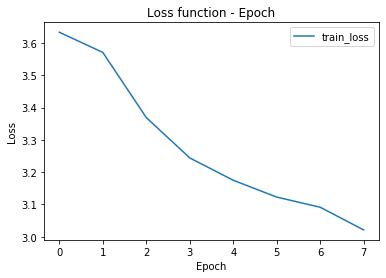

In [48]:
loss_function_epoch = L_list
#loss_function_epoch_val = DNN.L_list_val
plt.title('Loss function - Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss_function_epoch, label='train_loss')#, color='b'
#plt.plot(loss_function_epoch_val, label='val_loss')# color='b'
plt.legend(loc='best')

## 【問題9】出力サイズとパラメータ数の計算  
>CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。
>
>また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。
>
>以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。
>
>1  
>
>- 入力サイズ : 144×144, 3チャンネル
>- フィルタサイズ : 3×3, 6チャンネル
>- ストライド : 1
>- パディング : なし
>
>2 
>
>- 入力サイズ : 60×60, 24チャンネル
>- フィルタサイズ : 3×3, 48チャンネル
>- ストライド　: 1
>- パディング : なし
>
>3
>
>- 入力サイズ : 20×20, 10チャンネル
>- フィルタサイズ: 3×3, 20チャンネル
>- ストライド : 2
>- パディング : なし
>
>＊最後の例は丁度良く畳み込みをすることができない場合です。  
>フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算してください。  
>端が欠けてしまうので、こういった設定は好ましくないという例です。

#### 解答  


1  
- 出力サイズ : 142×6
- パラメータ数 : 124416
- バイアス項 : 6

2  
- 出力サイズ : 37×48
- パラメータ数 : 172800
- バイアス項 : 48

3  
- 出力サイズ : 9×20
- パラメータ数 : 8000
- バイアス項 : 20

以上